## Finding optimal hyperparameters for XGBoost

In [4]:
import os
import sys
import pandas as pd
import numpy as np  
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import metrics   # Additional sklearn functions
from sklearn.model_selection import GridSearchCV
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
import random
from decimal import Decimal

sys.path.append('..')
from Workflow import Workflow

In [2]:
wf = Workflow()
Xtrain, ytrain, Xvalid, yvalid, Xtest, ytest = wf.load_data()

In [5]:
def xgbfit(alg, Xtrain, ytrain, cv_folds=5, early_stopping_rounds=50):
    """
    Fits the XGBoost model using cross-validation to determine the optimal number of boosting rounds.
    
    Parameters:
    alg: The XGBoost model to be trained (should be an instance of XGBRegressor).
    Xtrain: Training features (input dataset).
    ytrain: Training target variable (output labels).
    cv_folds: Number of folds for cross-validation (default is 5).
    early_stopping_rounds: Number of rounds without improvement to stop training (default is 50).
    """
    
    # Get the parameters of the XGBoost model for cross-validation
    xgb_param = alg.get_xgb_params()
        
    # Convert the training data to the DMatrix format required by XGBoost
    xgtrain = xgb.DMatrix(Xtrain, ytrain)
        
    # Perform cross-validation to find the optimal number of boosting rounds
    cvresult = xgb.cv(
        xgb_param, 
        xgtrain, 
        num_boost_round=alg.get_params()['n_estimators'],  # Evaluate this many boosting rounds
        nfold=cv_folds,  # Number of folds for cross-validation
        metrics='rmse',  # Metric to optimize (Root Mean Squared Error)
        early_stopping_rounds=early_stopping_rounds  # Stop training if no improvement over this number of rounds
    )
        
    # Update the model's n_estimators to the optimal number found from cross-validation
    alg.set_params(n_estimators=cvresult.shape[0])
    print(f'Optimal n_estimators: {cvresult.shape[0]}')

    # Fit the model on the entire training dataset with the optimized number of boosting rounds
    alg.fit(Xtrain, ytrain)
        
    # Make predictions on the training set using the trained model
    dtrain_predictions = alg.predict(Xtrain)
        
    # Print a report summarizing model performance
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(ytrain, dtrain_predictions)))  # Calculate RMSE
    print("R2 Score : %.4g" % metrics.r2_score(ytrain, dtrain_predictions))  # Calculate R2 Score
                    
    # Calculate feature importances using the trained model's booster
    # 'importance_type' defines how feature importances are calculated (here using weight)
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    
    # Plot the feature importances
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')  # Set the y-axis label for the plot

Optimal n_estimators: 399

Model Report
RMSE : 46.46
R2 Score : 0.7858


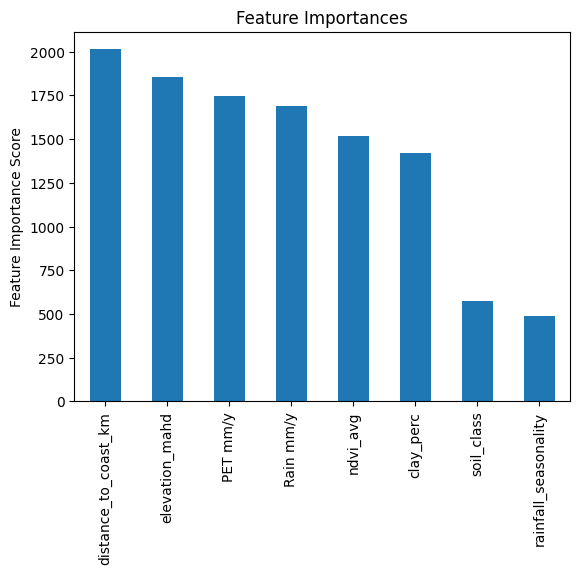

In [ ]:
# Initialize an instance of the XGBRegressor model with specified hyperparameters
xgb1 = XGBRegressor(
    learning_rate=0.1,               # Step size for each boosting round (higher values can lead to quicker convergence)
    n_estimators=1000,               # Maximum number of boosting rounds (trees) to be added to the model
    max_depth=5,                     # Maximum depth of each tree (controls overfitting)
    min_child_weight=1,              # Minimum sum of instance weight needed in a child (for controlling overfitting)
    gamma=0,                         # Minimum loss reduction required to make a further partition (regularization parameter)
    subsample=0.8,                   # Proportion of training data to use for each base learner (helps prevent overfitting)
    colsample_bytree=0.8,            # Proportion of features to use for each tree (helps prevent overfitting)
    objective='reg:squarederror',    # Objective function for regression tasks (square error)
    nthread=4,                       # Number of CPU threads to use for parallel processing
    seed=42                          # Random seed for reproducibility
)

# Specify the features (predictor variables) to be used for training the model
train_params = [
    'Rain mm/y', 
    'rainfall_seasonality', 
    'PET mm/y', 
    'elevation_mahd', 
    'distance_to_coast_km', 
    'ndvi_avg', 
    'clay_perc', 
    'soil_class'
]

# Specify the target variable (the variable to be predicted)
y_var = 'Recharge RC 50% mm/y'

# Fit the XGBoost model using the defined parameters on the training data
xgbfit(xgb1, Xtrain, ytrain)  # xgbfit is assumed to be a function defined elsewhere in the code that performs fitting using cross-validation